# Testing compatability of `ddls` with `rllib`

In [20]:
%load_ext autoreload
from ddls.environments.job_placing.job_placing_all_nodes_environment import JobPlacingAllNodesEnvironment
from ddls.devices.processors.gpus.A100 import A100
from ddls.distributions.uniform import Uniform
# from ddls.dgl_tests.rllib_model_test import GNNPolicy
from ddls.ml_models.policies import GNNPolicy
from ddls.plotting.plotting import plot_line

import ray
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print
ray.shutdown()
ray.init()

from ray.rllib.models import ModelCatalog
from ray.rllib.agents import ppo


from omegaconf import OmegaConf
from IPython.display import display
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Register the custom environment with `ray`

In [21]:
%autoreload
register_env('job_placing_all_nodes_environment', lambda env_config: JobPlacingAllNodesEnvironment(**env_config))

### Register the custom model with `rllib`

In [22]:
ModelCatalog.register_custom_model('my_model', GNNPolicy)

### Load `rllib` config

In [23]:
# # load config
# config = OmegaConf.load('configs/ddls_job_placing_rllib.yaml')
# print(OmegaConf.to_yaml(config))

# # convert config to dict so that is comparible with rllib
# config = OmegaConf.to_container(config, resolve=False)
# print(config)

In [67]:
%autoreload
node_config = {'type_1':
                  {
                      'num_nodes': 16,
                      'workers_config': 
                          [
                              {
                               'num_workers': 4,
#                                'worker': A100
                               'worker': 'ddls.devices.processors.gpus.A100.A100'
                              }
                          ]
                  }
              }

topology_config = {'type':
                      'torus',
                   'kwargs':
                      {
                          'x_dims': 4,
                          'y_dims': 4
                      }
                  }

jobs_config = {'path_to_files': '/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid',
               'job_interarrival_time_dist': Uniform(min_val=1, max_val=1000),
               'max_files': 1,
               'job_sampling_mode': 'remove'}


env_config = {'node_config': node_config,
              'topology_config': topology_config,
              'jobs_config': jobs_config,
              'reward_function': 'mean_job_completion_time',
              'pad_obs_kwargs': {'max_nodes': 200}


model_config = {
        'in_features_node':5,
        'in_features_edge':1,
        'out_features_msg':8,
        'out_features_hidden':16,
        'out_features':4,
        'in_features_graph':130,
        'out_features_graph':4,
        'num_layers':1,
        'aggregator_type':'mean'
    }



rllib_config = {
    
    'seed': 0,
    
    'env': 'job_placing_all_nodes_environment',
    
    'env_config': env_config,
    
    'batch_mode': 'complete_episodes',
    'train_batch_size': 32, # 128
    'sgd_minibatch_size': 32, # 128
    
    'model':{
            'fcnet_hiddens':[8],
            'fcnet_activation':'relu',
            'custom_model':'my_model',
            'custom_model_config': model_config
        },
    
    'framework': 'torch'
    
    }

# print(OmegaConf.to_yaml(rllib_config))
print(rllib_config)

{'seed': 0, 'env': 'job_placing_all_nodes_environment', 'env_config': {'node_config': {'type_1': {'num_nodes': 16, 'workers_config': [{'num_workers': 4, 'worker': 'ddls.devices.processors.gpus.A100.A100'}]}}, 'topology_config': {'type': 'torus', 'kwargs': {'x_dims': 4, 'y_dims': 4}}, 'jobs_config': {'path_to_files': '/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid', 'job_interarrival_time_dist': <ddls.distributions.uniform.Uniform object at 0x7fc7047478e0>, 'max_files': 1, 'job_sampling_mode': 'remove'}, 'reward_function': 'mean_job_completion_time', 'pad_obs_kwargs': {'max_nodes': 1000, 'max_edges': 1000}}, 'batch_mode': 'complete_episodes', 'train_batch_size': 32, 'sgd_minibatch_size': 32, 'model': {'fcnet_hiddens': [8], 'fcnet_activation': 'relu', 'custom_model': 'my_model', 'custom_model_config': {'in_features_node': 5, 'in_features_edge': 1, 'out_features_msg': 8, 'out_features_hidden': 16, 'out_features': 4, 'in_features_graph': 130, 'out_features_graph': 4, 'num_la

### Initialise an `rllib` epoch loop

In [68]:
%autoreload

# load default PPO config and update with custom config params
ppo_config = ppo.DEFAULT_CONFIG.copy()
ppo_config.update(rllib_config)
print(f'Config:\n{ppo_config}')

# initialise rllib trainer
epoch_loop = ppo.PPOTrainer(config=ppo_config)
print('\nInitialised trainer.')

2022-04-19 14:09:06,181	WARNING ppo.py:223 -- `train_batch_size` (32) cannot be achieved with your other settings (num_workers=2 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 16.


Config:
{'num_workers': 2, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 200, 'batch_mode': 'complete_episodes', 'gamma': 0.99, 'lr': 5e-05, 'train_batch_size': 32, 'model': {'fcnet_hiddens': [8], 'fcnet_activation': 'relu', 'custom_model': 'my_model', 'custom_model_config': {'in_features_node': 5, 'in_features_edge': 1, 'out_features_msg': 8, 'out_features_hidden': 16, 'out_features': 4, 'in_features_graph': 130, 'out_features_graph': 4, 'num_layers': 1, 'aggregator_type': 'mean'}}, 'optimizer': {}, 'horizon': None, 'soft_horizon': False, 'no_done_at_end': False, 'env': 'job_placing_all_nodes_environment', 'observation_space': None, 'action_space': None, 'env_config': {'node_config': {'type_1': {'num_nodes': 16, 'workers_config': [{'num_workers': 4, 'worker': 'ddls.devices.processors.gpus.A100.A100'}]}}, 'topology_config': {'type': 'torus', 'kwargs': {'x_dims': 4, 'y_dims': 4}}, 'jobs_config': {'path_to_files': '/scratch/datasets/ddls/jobs/tensorf

(RolloutWorker pid=1616212) 2022-04-19 14:09:15,837	WARNING catalog.py:558 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
(RolloutWorker pid=1616206) 2022-04-19 14:09:15,837	WARNING catalog.py:558 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-04-19 14:09:32,177	WARNING catalog.py:558 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2022-04-19 14:09:44,612	INFO trainable.py:127 -- Trainable.setup took 38.435 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-04-19 14:09:44,618	WARNING util.py:55 -- Install gputil for GPU system monitoring.



Initialised trainer.


### Run `rllib` on the `ddls` environment

In [69]:
%autoreload

agent_name = 'PPO'
num_epochs = 50
rl_training_stats = defaultdict(lambda: [])
for epoch in range(num_epochs):
    print(f'\n------- Epoch {epoch+1} of {num_epochs} -------')
    result = epoch_loop.train()
    
    # print epoch data
    print(pretty_print(result))
    
    # save epoch data
    for key, val in result['hist_stats'].items():
        rl_training_stats[key].extend(val)
    for _ in range(len(val)):
        rl_training_stats['seed'].append(result['config']['seed'])
        rl_training_stats['agent'].append(agent_name)
        rl_training_stats['epoch'].append(epoch)
        
# display(pd.DataFrame(rl_training_stats))


------- Epoch 1 of 50 -------
agent_timesteps_total: 32
custom_metrics: {}
date: 2022-04-19_14-10-09
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -4.313972618860607
episode_reward_mean: -4.427347580776664
episode_reward_min: -4.573115388954451
episodes_this_iter: 32
episodes_total: 32
experiment_id: eaaf7cc8db904daf90ebc465f5c2d63d
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.20000000000000007
        cur_lr: 4.999999999999999e-05
        entropy: 0.6931463479995728
        entropy_coeff: 0.0
        kl: 2.2570820874534547e-06
        policy_loss: -0.001816851149002711
        total_loss: 19.631890614827473
        vf_explained_var: 0.0
        vf_loss: 19.633706855773926
      model: {}
  num_agent_steps_sampled: 32
  num_agent_steps_trained: 32
  num_steps_sampled: 32
  num_steps_trained: 32
  num_steps_trained_this_iter: 32
iteration

agent_timesteps_total: 192
custom_metrics: {}
date: 2022-04-19_14-12-09
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -4.313972618860607
episode_reward_mean: -4.435769720804713
episode_reward_min: -4.573115388954451
episodes_this_iter: 32
episodes_total: 192
experiment_id: eaaf7cc8db904daf90ebc465f5c2d63d
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.006250000000000002
        cur_lr: 4.999999999999999e-05
        entropy: 0.6929364422957103
        entropy_coeff: 0.0
        kl: 4.040129715576768e-06
        policy_loss: -0.002415875842173894
        total_loss: 19.639929707845052
        vf_explained_var: 0.0
        vf_loss: 19.642345809936522
      model: {}
  num_agent_steps_sampled: 192
  num_agent_steps_trained: 192
  num_steps_sampled: 192
  num_steps_trained: 192
  num_steps_trained_this_iter: 32
iterations_since_restore: 6
node_i

agent_timesteps_total: 352
custom_metrics: {}
date: 2022-04-19_14-14-10
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -4.313972618860607
episode_reward_mean: -4.4072640160943894
episode_reward_min: -4.573115388954451
episodes_this_iter: 32
episodes_total: 352
experiment_id: eaaf7cc8db904daf90ebc465f5c2d63d
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.00019531250000000007
        cur_lr: 4.999999999999999e-05
        entropy: 0.6916120052337646
        entropy_coeff: 0.0
        kl: 1.3640843098983168e-05
        policy_loss: -0.004460051655769348
        total_loss: 19.341876792907716
        vf_explained_var: 0.0
        vf_loss: 19.346336809794106
      model: {}
  num_agent_steps_sampled: 352
  num_agent_steps_trained: 352
  num_steps_sampled: 352
  num_steps_trained: 352
  num_steps_trained_this_iter: 32
iterations_since_restore: 11
n

agent_timesteps_total: 512
custom_metrics: {}
date: 2022-04-19_14-16-14
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -4.313972618860607
episode_reward_mean: -4.446135431608467
episode_reward_min: -4.573115388954451
episodes_this_iter: 32
episodes_total: 512
experiment_id: eaaf7cc8db904daf90ebc465f5c2d63d
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        allreduce_latency: 0.0
        cur_kl_coeff: 6.103515625000002e-06
        cur_lr: 4.999999999999999e-05
        entropy: 0.6862544635931651
        entropy_coeff: 0.0
        kl: 3.936357776789616e-05
        policy_loss: -0.007564132908980051
        total_loss: 19.167017936706543
        vf_explained_var: 0.0
        vf_loss: 19.1745818456014
      model: {}
  num_agent_steps_sampled: 512
  num_agent_steps_trained: 512
  num_steps_sampled: 512
  num_steps_trained: 512
  num_steps_trained_this_iter: 32
iterations_since_restore: 16
node_i

agent_timesteps_total: 672
custom_metrics: {}
date: 2022-04-19_14-18-16
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -4.313972618860607
episode_reward_mean: -4.40467258839345
episode_reward_min: -4.573115388954451
episodes_this_iter: 32
episodes_total: 672
experiment_id: eaaf7cc8db904daf90ebc465f5c2d63d
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        allreduce_latency: 0.0
        cur_kl_coeff: 1.9073486328125006e-07
        cur_lr: 4.999999999999999e-05
        entropy: 0.6698225577672322
        entropy_coeff: 0.0
        kl: 9.037670582377663e-05
        policy_loss: -0.01111868948986133
        total_loss: 18.074748675028484
        vf_explained_var: 0.0
        vf_loss: 18.08586705525716
      model: {}
  num_agent_steps_sampled: 672
  num_agent_steps_trained: 672
  num_steps_sampled: 672
  num_steps_trained: 672
  num_steps_trained_this_iter: 32
iterations_since_restore: 21
node_i

agent_timesteps_total: 832
custom_metrics: {}
date: 2022-04-19_14-20-16
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -4.313972618860607
episode_reward_mean: -4.3968983052906365
episode_reward_min: -4.573115388954451
episodes_this_iter: 32
episodes_total: 832
experiment_id: eaaf7cc8db904daf90ebc465f5c2d63d
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        allreduce_latency: 0.0
        cur_kl_coeff: 5.9604644775390645e-09
        cur_lr: 4.999999999999999e-05
        entropy: 0.6273598392804464
        entropy_coeff: 0.0
        kl: 0.00020686536657853102
        policy_loss: -0.017797042553623518
        total_loss: 17.255901463826497
        vf_explained_var: 0.0
        vf_loss: 17.273698552449545
      model: {}
  num_agent_steps_sampled: 832
  num_agent_steps_trained: 832
  num_steps_sampled: 832
  num_steps_trained: 832
  num_steps_trained_this_iter: 32
iterations_since_restore: 26
n

agent_timesteps_total: 992
custom_metrics: {}
date: 2022-04-19_14-22-15
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -4.313972618860607
episode_reward_mean: -4.3735754559821896
episode_reward_min: -4.573115388954451
episodes_this_iter: 32
episodes_total: 992
experiment_id: eaaf7cc8db904daf90ebc465f5c2d63d
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        allreduce_latency: 0.0
        cur_kl_coeff: 1.8626451492309577e-10
        cur_lr: 4.999999999999999e-05
        entropy: 0.5371777375539144
        entropy_coeff: 0.0
        kl: 0.00033872347751942773
        policy_loss: -0.017252099762360255
        total_loss: 15.42913745244344
        vf_explained_var: 7.351239522298177e-08
        vf_loss: 15.446389738718668
      model: {}
  num_agent_steps_sampled: 992
  num_agent_steps_trained: 992
  num_steps_sampled: 992
  num_steps_trained: 992
  num_steps_trained_this_iter: 32
iterations_si

agent_timesteps_total: 1152
custom_metrics: {}
date: 2022-04-19_14-24-13
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -4.313972618860607
episode_reward_mean: -4.360618317477497
episode_reward_min: -4.573115388954451
episodes_this_iter: 32
episodes_total: 1152
experiment_id: eaaf7cc8db904daf90ebc465f5c2d63d
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        allreduce_latency: 0.0
        cur_kl_coeff: 5.820766091346743e-12
        cur_lr: 4.999999999999999e-05
        entropy: 0.3777811874945958
        entropy_coeff: 0.0
        kl: 0.0004974967136520311
        policy_loss: -0.028009228159983954
        total_loss: 13.659988371531169
        vf_explained_var: 0.0
        vf_loss: 13.687998008728027
      model: {}
  num_agent_steps_sampled: 1152
  num_agent_steps_trained: 1152
  num_steps_sampled: 1152
  num_steps_trained: 1152
  num_steps_trained_this_iter: 32
iterations_since_restore: 3

agent_timesteps_total: 1312
custom_metrics: {}
date: 2022-04-19_14-26-15
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -4.313972618860607
episode_reward_mean: -4.326929757365297
episode_reward_min: -4.573115388954451
episodes_this_iter: 32
episodes_total: 1312
experiment_id: eaaf7cc8db904daf90ebc465f5c2d63d
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        allreduce_latency: 0.0
        cur_kl_coeff: 1.818989403545857e-13
        cur_lr: 4.999999999999999e-05
        entropy: 0.22208516548077264
        entropy_coeff: 0.0
        kl: 0.0003430034266784787
        policy_loss: -0.021367629120747248
        total_loss: 11.171199989318847
        vf_explained_var: 0.0
        vf_loss: 11.192567348480225
      model: {}
  num_agent_steps_sampled: 1312
  num_agent_steps_trained: 1312
  num_steps_sampled: 1312
  num_steps_trained: 1312
  num_steps_trained_this_iter: 32
iterations_since_restore: 

agent_timesteps_total: 1472
custom_metrics: {}
date: 2022-04-19_14-28-16
done: false
episode_len_mean: 1.0
episode_media: {}
episode_reward_max: -4.313972618860607
episode_reward_mean: -4.3217469019634205
episode_reward_min: -4.573115388954451
episodes_this_iter: 32
episodes_total: 1472
experiment_id: eaaf7cc8db904daf90ebc465f5c2d63d
hostname: mammoth.ee.ucl.ac.uk
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        allreduce_latency: 0.0
        cur_kl_coeff: 5.684341886080803e-15
        cur_lr: 4.999999999999999e-05
        entropy: 0.10906619305411974
        entropy_coeff: 0.0
        kl: 0.00023688820704895381
        policy_loss: -0.03175179002185662
        total_loss: 8.485252539316813
        vf_explained_var: 0.0
        vf_loss: 8.517004172007242
      model: {}
  num_agent_steps_sampled: 1472
  num_agent_steps_trained: 1472
  num_steps_sampled: 1472
  num_steps_trained: 1472
  num_steps_trained_this_iter: 32
iterations_since_restore: 4

Plotting metric episode_reward


<Figure size 1920x1440 with 0 Axes>

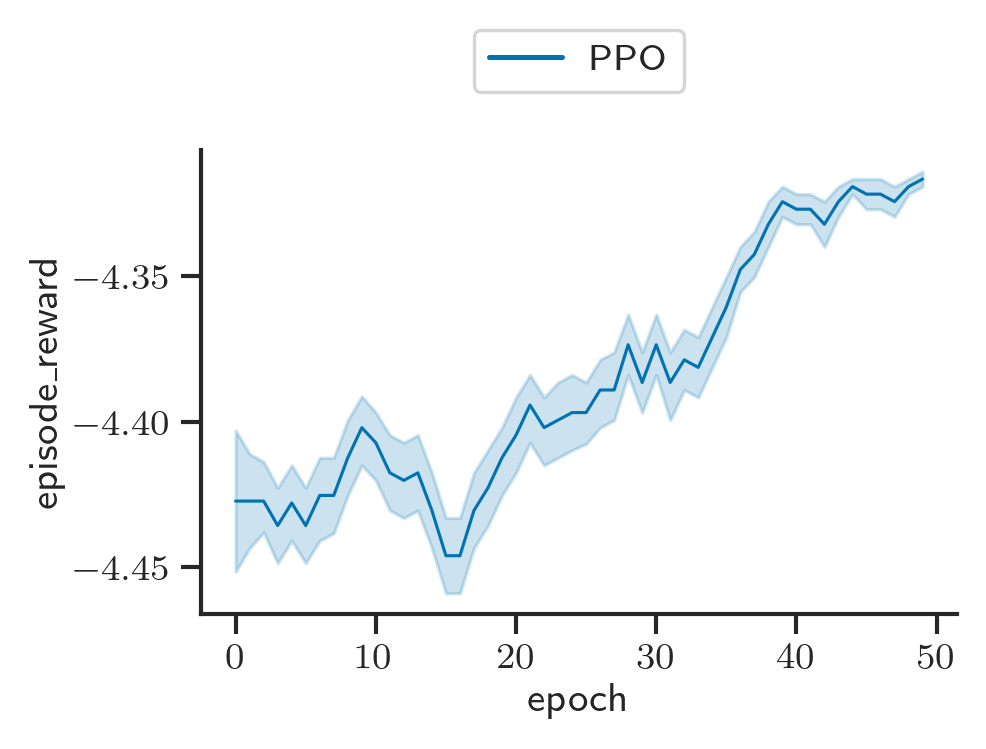

Plotting metric episode_lengths


<Figure size 1920x1440 with 0 Axes>

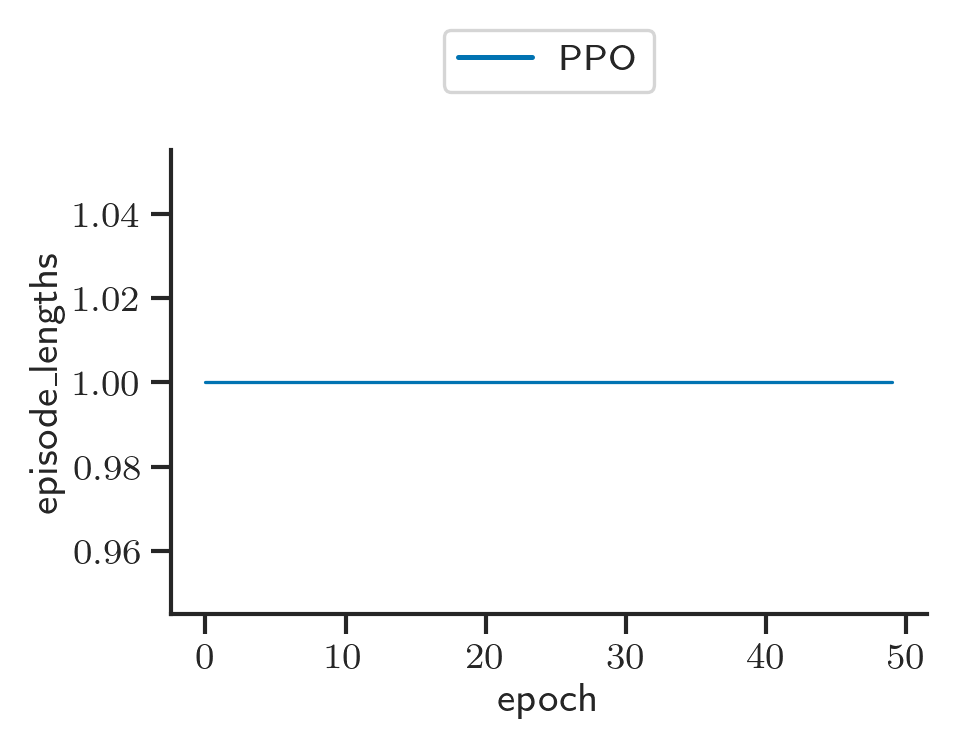

In [70]:
x = 'epoch'
scaling_factor = 1
metrics_to_plot = {'episode_reward', 'episode_lengths'}

for metric in metrics_to_plot:
    print(f'Plotting metric {metric}')
    fig = plt.figure()
    fig = plot_line(pd.DataFrame(rl_training_stats), 
                    x=x, 
                    y=metric, 
                    hue='agent', 
                    xlabel=x, 
                    ylabel=metric, 
                    err_style='band', # 'band' 'bars'
                    ci=68, # 95 68
                    scaling_factor=scaling_factor,
                    show_fig=False)
#     plt.axhline(y=np.mean(random_baseline_stats[metric]), linestyle='--', color='#a84a32', label='Random')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2)
    plt.show()

In [74]:
a = {'hello': 1,
     'hello2': 2}
a.update({'hello3': 3})
print(a)

{'hello': 1, 'hello2': 2, 'hello3': 3}
